# **Collaborative Filtering for Netflix Movie Ratings**


## **Overview**

In this project, I aim to build two models for collaborative filtering using a reduced dataset from Netflix's movie ratings database: 

1) Matrix Factorization;
2) Gaussian Mixture Model (estimate parameters with EM algorithm);

In our problem, any particular user has rated only a fraction of the movies, so the data matrix is only partially filled. The goal here is to fill all the remaining entries of the matrix, and then compare the predicted matrix with the true complete matrix using the Root Mean Squared Error (RMSE) metric.

We'll apply both models to the same dataset and compare their performance.

This Matrix Completion approach also represents a powerful way to handle missing data at a massive scale.

In [105]:
from typing import NamedTuple, Tuple  
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import logsumexp
from scipy.linalg import lstsq

In [108]:
## Loading data:
X = np.loadtxt("./data/netflix_incomplete.txt") 
X_true = np.loadtxt("./data/netflix_complete.txt")


Let $X$ denote our $(n,d)$ ratings matrix. The rows of this matrix correspond to users and columns specify movies so that $X[u,i]$ gives the rating value of user $u$ for movie $i$ (if available). 

Both $n$ and $d$ are typically quite large. The ratings range from one to five stars and are mapped to integers $\{1,2,3,4,5\}$. 

In a realistic setting, most of the entries of $X$ are missing. For this reason, we define:

 $C_u$ as the set of movies (column indexes) that user $u$ has rated;
 $H_u$ as its complement (the set of remaining unwatched/unrated movies we wish to predict ratings for). 
 
 We use $|C_u|$ to denote the number of observed rating values from user $u$. From the point of view of our mixture model, each user $u$ is an example $x^{(u)} = X[u,:]$.
 
 But since most of the coordinates of $x^{(u)}$ are missing, we need to focus the model during training on just the observed portion. 
 
 To this end, we use $x_{C_u}^{(u)} = \{x_i^{(u)} : i \in C_u\}$ as the vector of only observed ratings.

In [3]:
# Criando DataFrames para X e X_true
df_X = pd.DataFrame(X, columns=[f'Movie_{i+1}' for i in range(X.shape[1])], index=[f'User_{i+1}' for i in range(X.shape[0])])
df_X_true = pd.DataFrame(X_true, columns=[f'Movie_{i+1}' for i in range(X_true.shape[1])], index=[f'User_{i+1}' for i in range(X_true.shape[0])])


In [4]:
df_X_true

,Movie_1,Movie_2,Movie_3,Movie_4,Movie_5,Movie_6,Movie_7,Movie_8,Movie_9,Movie_10,...,Movie_1191,Movie_1192,Movie_1193,Movie_1194,Movie_1195,Movie_1196,Movie_1197,Movie_1198,Movie_1199,Movie_1200
User_1,2.0,4.0,5.0,4.0,4.0,3.0,5.0,4.0,4.0,2.0,...,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0
User_2,3.0,5.0,5.0,3.0,4.0,3.0,5.0,4.0,2.0,4.0,...,3.0,4.0,2.0,4.0,4.0,3.0,3.0,5.0,3.0,4.0
User_3,2.0,4.0,4.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,...,3.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,4.0,3.0
User_4,4.0,3.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,4.0,...,3.0,4.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0
User_5,2.0,2.0,5.0,4.0,4.0,1.0,5.0,4.0,5.0,3.0,...,1.0,4.0,4.0,3.0,2.0,5.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_1196,2.0,4.0,5.0,3.0,5.0,3.0,5.0,4.0,4.0,5.0,...,5.0,2.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0
User_1197,2.0,4.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,2.0,...,2.0,2.0,3.0,1.0,3.0,5.0,3.0,3.0,3.0,3.0
User_1198,2.0,3.0,5.0,4.0,3.0,1.0,3.0,2.0,3.0,3.0,...,3.0,2.0,4.0,2.0,3.0,4.0,2.0,3.0,4.0,2.0
User_1199,3.0,4.0,5.0,4.0,4.0,4.0,5.0,3.0,4.0,3.0,...,3.0,4.0,5.0,4.0,2.0,5.0,4.0,4.0,5.0,4.0


In [5]:
df_X

,Movie_1,Movie_2,Movie_3,Movie_4,Movie_5,Movie_6,Movie_7,Movie_8,Movie_9,Movie_10,...,Movie_1191,Movie_1192,Movie_1193,Movie_1194,Movie_1195,Movie_1196,Movie_1197,Movie_1198,Movie_1199,Movie_1200
User_1,2.0,4.0,5.0,0.0,0.0,3.0,5.0,0.0,4.0,2.0,...,4.0,0.0,0.0,4.0,0.0,5.0,4.0,4.0,4.0,4.0
User_2,3.0,5.0,5.0,3.0,4.0,3.0,5.0,4.0,2.0,4.0,...,3.0,4.0,2.0,4.0,4.0,3.0,3.0,5.0,3.0,4.0
User_3,2.0,0.0,4.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,...,3.0,4.0,0.0,0.0,0.0,3.0,2.0,4.0,4.0,3.0
User_4,4.0,3.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,4.0,...,3.0,4.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0
User_5,2.0,2.0,5.0,4.0,0.0,1.0,5.0,0.0,5.0,3.0,...,1.0,4.0,0.0,3.0,2.0,5.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_1196,2.0,4.0,5.0,3.0,5.0,3.0,5.0,4.0,4.0,5.0,...,5.0,2.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0
User_1197,0.0,4.0,5.0,0.0,4.0,0.0,3.0,0.0,4.0,2.0,...,2.0,0.0,3.0,1.0,3.0,5.0,3.0,3.0,3.0,3.0
User_1198,2.0,3.0,5.0,4.0,3.0,1.0,3.0,2.0,3.0,3.0,...,3.0,2.0,0.0,2.0,3.0,0.0,2.0,3.0,4.0,2.0
User_1199,3.0,4.0,0.0,4.0,4.0,4.0,5.0,3.0,4.0,3.0,...,3.0,4.0,5.0,4.0,2.0,5.0,4.0,4.0,5.0,4.0


In [6]:
null_percentage = (df_X == 0.0).sum().sum() / df_X.size * 100

print(f"Percentage of entries equal to 0.0 in df_X: {null_percentage:.2f}%")


Percentage of entries equal to 0.0 in df_X: 22.79%


## **1. Matrix Factorization**

#### **1.1. Definition:**

In order to perform the collaborative filtering approach through Matrix Factorization, we impose an additional constraint on $X$:

$$X = UV^T$$

for some $n \times d$ matrix $U$ and $d \times m$ matrix $V^T$. 

In this case, we say that $X$ has **rank** at least $d$. In other words, the **rank** of a matrix $X$ is the smallest number $d$ for which there exists some $n \times d$ matrix $U$ and $m \times d$ matrix $V$ with $UV^T = X$. 

Then, we formulate an objective function in terms of $U$ and $V$:


$$J = \sum_{(a,i)\in D} \frac{(Y_{ai} - [UV^T]_{ai})^2}{2} + \frac{\lambda}{2}\left(\sum_{a,k} U_{ak}^2 + \sum_{i,k} V_{ik}^2\right)$$


In order to solve this problem, we'll use iterative optimization, i.e. we fix $U$ and solve for $V$, then fix $V$ to be the result from the previous step and solve for $U$, and repeat this alternate process until we find the solution.

#### **1.2. Implementation:**

In [21]:
class MatrixFactorization:
    
    def __init__(self, rank=5, lambda_reg=0.5, iterations=100):
        self.rank = rank
        self.lambda_reg = lambda_reg
        self.iterations = iterations

    # Optimize U matrix given a fixed V matrix
    def optimize_U(self, X, V_fixed):
        """Optimize U for fixed V"""
        n_users, n_movies = X.shape
        mask = (X != 0)
        U_new = np.zeros((n_users, self.rank))
        
        for u in range(n_users):
            # Get only movies rated by the user
            rated_movies = mask[u]
            if np.sum(rated_movies) > 0:
                V_u = V_fixed[:, rated_movies].T  # Transpose for correct dimensions
                x_u = X[u, rated_movies]
                
                # Use lstsq to solve the overdetermined system
                U_new[u] = lstsq(V_u, x_u)[0]

        return U_new
    
    # Optimize V matrix given a fixed U matrix
    def optimize_V(self, X, U_fixed):
        """Optimize V for fixed U"""
        n_users, n_movies = X.shape
        mask = (X != 0)
        V_new = np.zeros((self.rank, n_movies))
        
        for i in range(n_movies):
            # Get only users who rated the movie
            users_rated = mask[:, i]
            if np.sum(users_rated) > 0:
                U_i = U_fixed[users_rated]
                x_i = X[users_rated, i]
                
                # Use lstsq to solve the overdetermined system
                V_new[:, i] = lstsq(U_i, x_i)[0]
        
        return V_new

    # Calculate the loss function including error and regularization terms
    def calculate_loss(self, X, U, V):
        mask = (X != 0)
        predictions = U @ V
        error_term = np.sum(mask * (X - predictions)**2)
        reg_term = (self.lambda_reg/2) * (np.sum(U**2) + np.sum(V**2))
        return error_term + reg_term

    # Train the model using alternating optimization of U and V
    def train(self, X, X_test=None):
        n_users, n_movies = X.shape
        
        # Randomly initialize only V
        self.V = np.random.normal(3, 1, (self.rank, n_movies)) 
        
        self.loss_history = []
        self.test_error_history = []
        
        previous_loss = float('inf')
        
        for epoch in range(self.iterations):
            # Optimize U with fixed V
            self.U = self.optimize_U(X, self.V)
            
            # Optimize V with fixed U
            self.V = self.optimize_V(X, self.U)
            
            # Calculate loss
            current_loss = self.calculate_loss(X, self.U, self.V)
            self.loss_history.append(current_loss)
            
            # Check for convergence
            if abs(current_loss - previous_loss) < 0.01:
                print(f'Converged at epoch {epoch}')
                break
                
            previous_loss = current_loss
            
            if X_test is not None:
                X_mf = np.round(self.predict(X))
                test_error = self.rmse(X_mf,X_true)
                self.test_error_history.append(test_error)
            
            print(f'Epoch {epoch}: Loss = {current_loss:.4f}')

    # Predict ratings by multiplying U and V matrices
    def predict(self, X):
        n_users, n_movies = X.shape
        predictions = np.clip(self.U @ self.V, 1, 5) ## Use clip for restricting X values to be between 1 and 5 (admissible range for rating)
        X_pred = X.copy()

        for i in range(n_users):
            mask0 = X[i, :] == 0
            X_pred[i, mask0] = predictions[i, mask0]
        return X_pred
        

    # Calculate RMSE between true and predicted ratings
    def rmse(self, X, X_true):
        return np.sqrt(np.mean((X_true - X)**2))

In [28]:
# Train and evaluate the model
mf = MatrixFactorization(
    rank=3,
    lambda_reg=0.001,
    iterations=10
)

mf.train(X, X_test=X_true)
X_mf = np.round(mf.predict(X))

rmse_mf = mf.rmse(X_mf,X_true)
print(f'Final RMSE: {rmse_mf}')


Epoch 0: Loss = 827339.5013
Epoch 1: Loss = 745363.6165
Epoch 2: Loss = 738976.4529
Epoch 3: Loss = 737115.6401
Epoch 4: Loss = 736245.8856
Epoch 5: Loss = 735762.9632
Epoch 6: Loss = 735475.5605
Epoch 7: Loss = 735302.4402
Epoch 8: Loss = 735198.9191
Epoch 9: Loss = 735137.6499
Final RMSE: 0.5025939657859457


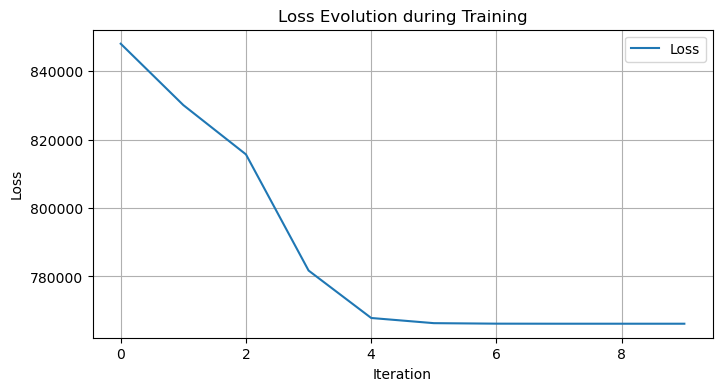

In [24]:
# Plotting loss 

plt.figure(figsize=(8, 4))
plt.plot(mf.loss_history, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Evolution during Training')
plt.legend()
plt.grid(True)
plt.show()

plt.show()

In [25]:
df_X_mf = pd.DataFrame(X_mf, columns=[f'Movie_{i+1}' for i in range(X_mf.shape[1])])
df_X_mf.index.name = 'User'
df_X_mf.head()

,Movie_1,Movie_2,Movie_3,Movie_4,Movie_5,Movie_6,Movie_7,Movie_8,Movie_9,Movie_10,...,Movie_1191,Movie_1192,Movie_1193,Movie_1194,Movie_1195,Movie_1196,Movie_1197,Movie_1198,Movie_1199,Movie_1200
User,,,,,,,,,,,,,,,,,,,,,
0,2.0,4.0,5.0,4.0,4.0,3.0,5.0,3.0,4.0,2.0,...,4.0,3.0,3.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0
1,3.0,5.0,5.0,3.0,4.0,3.0,5.0,4.0,2.0,4.0,...,3.0,4.0,2.0,4.0,4.0,3.0,3.0,5.0,3.0,4.0
2,2.0,3.0,4.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,...,3.0,4.0,2.0,2.0,3.0,3.0,2.0,4.0,4.0,3.0
3,4.0,3.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,4.0,...,3.0,4.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0
4,2.0,2.0,5.0,4.0,4.0,1.0,5.0,2.0,5.0,3.0,...,1.0,4.0,2.0,3.0,2.0,5.0,3.0,4.0,3.0,3.0


## **2. Gaussian Mixture Model**


#### **2.1. Definition:**



$$P(x|\theta) = \sum_{j=1}^K \pi_j\mathcal{N}(x; \mu^{(j)}, \sigma_j^2I)$$


where $\theta$ denotes all the parameters in the mixture (means $\mu^{(j)}$, mixing proportions $\pi_j$, and variances $\sigma_j^2$). We'll use the EM algorithm to estimate these unknown parameters by maximizing the log-likelihood.

#### **2.2. Implementation:**


**2.1.** Define a class to hold the Gaussian Mixture Model parameters


In [11]:
class GaussianMixture(NamedTuple):
    """Tuple holding a gaussian mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds to a gaussian component mean
    var: np.ndarray  # (K, ) array - each row corresponds to the variance of a component
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component

**2.2.** Define a function to randomly initialize the GMM parameters


In [12]:
def init(X: np.ndarray, K: int,
         seed: int = 1) -> Tuple[GaussianMixture, np.ndarray]:
    """Initializes the mixture model with random points as initial
    means and uniform assingments

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed

    Returns:
        mixture: the initialized gaussian mixture
        post: (n, K) array holding the soft counts
            for all components for all examples

    """
    np.random.seed(seed)
    n, _ = X.shape
    p = np.ones(K) / K

    # select K random points as initial means
    mu = X[np.random.choice(n, K, replace=False)]
    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((X - mu[j])**2).mean()

    mixture = GaussianMixture(mu, var, p)
    post = np.ones((n, K)) / K

    return mixture, post

#### **2.3. Evaluation:**

In [13]:
def rmse(X, Y):
    return np.sqrt(np.mean((X - Y)**2))


def bic(X: np.ndarray, mixture: GaussianMixture,
        log_likelihood: float) -> float:
    """Computes the Bayesian Information Criterion for a
    mixture of gaussians

    Args:
        X: (n, d) array holding the data
        mixture: a mixture of spherical gaussian
        log_likelihood: the log-likelihood of the data

    Returns:
        float: the BIC for this mixture
    """

    n, d = X.shape
    K = mixture.mu.shape[0]

    # Número de parâmetros
    p = K * d + K + (K - 1)

    # Cálculo do BIC
    bic_value = log_likelihood - (p / 2) * np.log(n)
    
    return bic_value

## **Expectation–Maximization Algorithm**


The EM algorithm proceeds by iteratively assigning (softly) users to types (E-step) and subsequently re-estimating the Gaussians associated with each type (M-step). 
Once we have the mixture, we can use it to predict values for all the missing entries in the data matrix.

### **E-step**



We use Bayes' rule to find an updated expression for the posterior probability:


$$p(j|u) = \frac{p(u|j) \cdot p(j)}{p(u)} = \frac{p(u|j) \cdot p(j)}{\sum_{j=1}^K p(u|j) \cdot p(j)} = \frac{\pi_j\mathcal{N}(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma_j^2 I_{C_u \times C_u})}{\sum_{j=1}^K \pi_j\mathcal{N}(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma_j^2 I_{C_u \times C_u})}$$

To minimize numerical instability, we implement the **E-step** in the **log-domain**:

$$\ell(j|u) \;=\; \log(p(j|u)) = \log \left(\frac{\pi_j\mathcal{N}(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma_j^2 I_{C_u \times C_u})}{\sum_{j=1}^K \pi_j\mathcal{N}(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma_j^2 I_{C_u \times C_u})}\right)$$
$$\phantom{\ell(j|u)} \;=\; \log \left(\pi_j\mathcal{N}(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma_j^2 I_{C_u \times C_u})\right) - \log \left(\sum_{j=1}^K \pi_j\mathcal{N}(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma_j^2 I_{C_u \times C_u})\right)$$
$$\phantom{\ell(j|u)} \;=\; \log(\pi_j) + \log \left(\mathcal{N}(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma_j^2 I_{C_u \times C_u})\right) - \log \left(\sum_{j=1}^K \exp(\log(\pi_j\mathcal{N}(x_{C_u}^{(u)}; \mu_{C_u}^{(j)}, \sigma_j^2 I_{C_u \times C_u})))\right)$$
$$\phantom{\ell(j|u)} \;=\; f(u,j) - \log \left(\sum_{j=1}^K \exp(f(u,j))\right)$$


And with the expression above, we proceed to implementation.

#### **Implementation:**


In [14]:
## Writing a function to compute the log probabbility will be useful 
def log_gaussian(x: np.ndarray, mean: np.ndarray, var: float) -> float:
    """Computes the log probablity of vector x under a normal distribution

    Args:
        x: (d, ) array holding the vector's coordinates
        mean: (d, ) mean of the gaussian
        var: variance of the gaussian

    Returns:
        float: the log probability
    """
    d = len(x)
    # Calculate the log probability for the Gaussian distribution 
    log_prob = -d / 2.0 * np.log(2 * np.pi * var)
    log_prob -= 0.5 * ((x - mean)**2).sum() / var
    return log_prob

## E-step
def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment

    """
    n, _ = X.shape
    K, _ = mixture.mu.shape
    # Initialize the posterior probability matrix with zeros
    post = np.zeros((n, K))

    ll = 0
    for i in range(n):
        # Create a mask to identify non-zero entries in the data point
        mask = (X[i, :] != 0)
        for j in range(K):
            # Calculate the log likelihood of the data point belonging to the j-th Gaussian component
            log_likelihood = log_gaussian(X[i, mask], mixture.mu[j, mask],
                                          mixture.var[j])
            # Update the posterior probability with the log of the mixture probability and the log likelihood
            post[i, j] = np.log(mixture.p[j] + 1e-16) + log_likelihood
        total = logsumexp(post[i, :])
        post[i, :] = post[i, :] - total
        # Accumulate the total log likelihood
        ll += total

    # Return the non-log posterior probabilities and the total log likelihood
    return np.exp(post), ll

### **M-step**


We wish to find the parameters $\pi$, $\mu$, and $\sigma$ that maximize the proxy likelihood function $\hat{\ell}(X;\theta)$:

$$\hat{\ell} (X; \theta) = \sum_{u=1}^n \sum_{j=1}^K p(j|u) \log \left(\frac{p(x^{(u)} \text{ generated by cluster } j; \theta)}{p(j|u)}\right)$$
$$= \sum_{u=1}^n \sum_{j=1}^K p(j|u) \log \left(\frac{\pi_j \mathcal{N}(x_{\mathcal{C}u}^{(u)} | \mu{\mathcal{C}u}^{(j)}, \sigma_j^2 I{|\mathcal{C}u| \times |\mathcal{C}_u|})}{p(j|u)}\right)$$

Then, by taking partial derivatives with respect to parameters $\pi$, $\mu$ and $\sigma$, and then setting equal to zero, we obtain the following optimal expressions for the parameters:

$$\widehat{\mu_l^{(k)}} = \frac{\sum_{u=1}^n p(k|u) \delta(l, C_u) x_l^{(u)}}{\sum_{u=1}^n p(k|u) \delta(l, C_u)} ;$$

$$\widehat{\sigma_k^2} = \frac{1}{\sum_{u=1}^n |C_u|p(k|u)} \sum_{u=1}^n p(k|u) \|x_{C_u}^{(u)} - \mu_{C_u}^{(k)}\|^2 ;$$

$$\widehat{\pi_k} = \frac{1}{n} \sum_{u=1}^n p(k|u) .$$





#### **Implementation:**


In [15]:
def mstep(X: np.ndarray, post: np.ndarray, mixture: GaussianMixture,
          min_variance: float = .25) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        post: (n, K) array holding the soft counts
            for all components for all examples
        mixture: the current gaussian mixture
        min_variance: the minimum variance for each gaussian

    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    _, K = post.shape

    n_hat = post.sum(axis=0)
    p = n_hat / n

    mu = mixture.mu.copy()
    var = np.zeros(K)

    for j in range(K):
        sse, weight = 0, 0
        for l in range(d):
            mask = (X[:, l] != 0)
            n_sum = post[mask, j].sum()
            if (n_sum >= 1):
                # Updating mean
                mu[j, l] = (X[mask, l] @ post[mask, j]) / n_sum
            # Computing variance
            sse += ((mu[j, l] - X[mask, l])**2) @ post[mask, j]
            weight += n_sum
        var[j] = sse / weight
        if var[j] < min_variance:
            var[j] = min_variance

    return GaussianMixture(mu, var, p)

#### **Running the EM algorithm**


In [16]:
def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """

    prev_ll = None
    ll = None
    while (prev_ll is None or ll - prev_ll > 1e-6 * np.abs(ll)):
        prev_ll = ll
        post, ll = estep(X, mixture)
        mixture = mstep(X, post, mixture)

    return mixture, post, ll

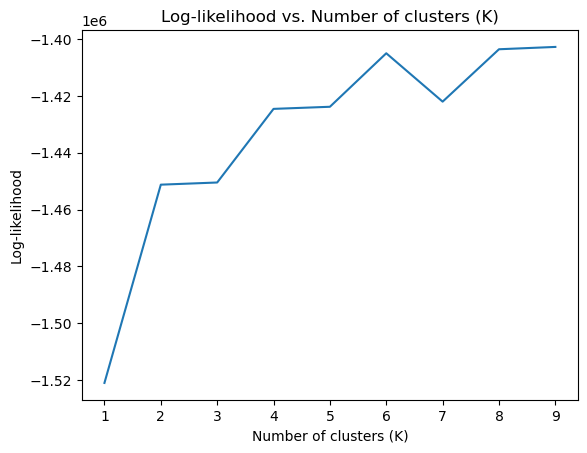

In [17]:
# This code is used to test the log likelihood for different values of K.
# It may take a while to run.
# Feel free to try different settings

log_likelihoods = []

for K in range(1, 10):
    
    # Initialization
    mixture, post = init(X, K)
    
    # Running the EM algorithm
    mixture, post, log_likelihood = run(X, mixture, post)
    
    log_likelihoods.append(log_likelihood)

# Plotting the log-likelihood curve
plt.plot(range(1, 10), log_likelihoods)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood vs. Number of clusters (K)')
plt.show()

We can see that by increasing K from 6 to 7, there is a decrease in log-likelihood, suggesting that **K** > 6 will be reasonable in terms of balancing the model's accuracy and complexity.

### **Matrix completion**


Now that we have a mixture model, we use it to complete the partially observed rating matrix

In [18]:
def fill_matrix(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """Fills an incomplete matrix according to a mixture model

    Args:
        X: (n, d) array of incomplete data (incomplete entries =0)
        mixture: a mixture of gaussians

    Returns
        np.ndarray: a (n, d) array with completed data
    """
    n, d = X.shape
    X_pred = X.copy()
    K, _ = mixture.mu.shape

    for i in range(n):
        mask = X[i, :] != 0
        mask0 = X[i, :] == 0
        post = np.zeros(K)
        for j in range(K):
            log_likelihood = log_gaussian(X[i, mask], mixture.mu[j, mask],
                                          mixture.var[j])
            post[j] = np.log(mixture.p[j]) + log_likelihood
        post = np.exp(post - logsumexp(post))
        X_pred[i, mask0] = np.dot(post, mixture.mu[:, mask0])
    return X_pred

In [19]:
# Initialization
K = 6 # number of clusters
mixture, post = init(X, K)
    
# Running the EM algorithm
mixture, post, log_likelihood = run(X, mixture, post)

# Filling the sparse matrix
X_gmm = np.round(fill_matrix(X, mixture)).astype(int)

# Comparing the predicted matrix with the true matrix
rmse_gmm = rmse(X_gmm, X_true)

print(rmse_gmm)


0.5012131116933528


In [20]:
df_X_gmm = pd.DataFrame(X_gmm, columns=[f'Movie_{i+1}' for i in range(X_gmm.shape[1])])
df_X_gmm.index.name = 'User'
df_X_gmm.head()


,Movie_1,Movie_2,Movie_3,Movie_4,Movie_5,Movie_6,Movie_7,Movie_8,Movie_9,Movie_10,...,Movie_1191,Movie_1192,Movie_1193,Movie_1194,Movie_1195,Movie_1196,Movie_1197,Movie_1198,Movie_1199,Movie_1200
User,,,,,,,,,,,,,,,,,,,,,
0,2,4,5,4,4,3,5,3,4,2,...,4,3,3,4,3,5,4,4,4,4
1,3,5,5,3,4,3,5,4,2,4,...,3,4,2,4,4,3,3,5,3,4
2,2,3,4,3,3,1,3,3,3,3,...,3,4,3,2,2,3,2,4,4,3
3,4,3,4,4,5,2,4,5,4,4,...,3,4,5,4,5,4,4,4,4,4
4,2,2,5,4,4,1,5,2,5,3,...,1,4,3,3,2,5,3,4,3,3


## **Conclusion**

In this project, we implemented and compared two models for collaborative filtering:

1. Matrix Factorization (MF): RMSE = **0.5026**
2. Gaussian Mixture Model (GMM): RMSE = **0.5012**

Both models demonstrated satisfactory performance, achieving nearly identical accuracy on the test data.

However, there are some important aspects to consider:

- **Ease of Implementation:** MF models are simpler to implement, as the theoretical framework behind the EM algorithm used in GMMs can be quite complex.
- **Explainability:** MF models are preferable in many scenarios due to their straightforward nature, which enhances their interpretability.
- **Computational demand:** GMMs generally require more computational power compared to MF models.

**Guarantees:**

We are guaranteed to do a local convergence, but there is no guarantee to get to the global optima. And you can easily think about examples when, if we initialize incorrectly, we can actually get really bad results.

So what we do here is to do several random initialization and select, again, the values which give you the best result on the development set.

This simple algorithm can find connections between different users and products, solving the non-trivial problem of product recommendation.



